In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np

from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, plot_overview, clamp, load_image, make_dir
import keras
from keras import datasets 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


no display found. Using non-interactive Agg backend


Using TensorFlow backend.
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
def get_beta(i, num_iter):
    """
    Helper method for beta growth
    """
    start_beta, end_beta = 10.0, 100.0
    return start_beta * (end_beta / start_beta) ** (i / num_iter)

# def np_img_to_tensor(grayscale_img):
#     rgb_img = np.repeat(grayscale_img[..., np.newaxis], 3, -1)
#     im = Image.fromarray(rgb_img)
#     x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
#     x = x.unsqueeze(0).to(device)
#     return x

def np_img_to_tensor(input_img,data_mean,data_std, device, num_ch=1):
    if num_ch == 1:
        rgb_img = np.repeat(input_img[..., np.newaxis], 3, -1)
    else:
        rgb_img = input_img
    im = Image.fromarray(rgb_img)
    x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
    x = x.unsqueeze(0).to(device)
    return x

In [3]:
# args
args_cuda = True
args_method = 'guided_backprop'
args_beta_growth = None
args_num_iter = 1500
args_prefactors = [1e11, 1e6]
args_lr = 1* (10**(-3))
args_output_dir = '../output/'
args_role = 'adversary'
args_dataset = 'fmnist'
target_class_idx = 0
attack_method = 'cwl2/conf_0'
args_adv_dir = '../../xai-adv/data/postndss/{}/{}/target_next/target_{}/{}/'
num_ch = 1
side = 28

In [4]:
# options
device = torch.device("cuda" if args_cuda else "cpu")
method = getattr(ExplainingMethod, args_method)
print('Explanation method {} will be used'.format(method))

# load model
data_mean = np.array([0.0, 0.0, 0.0])
data_std = np.array([1.0, 1.0, 1.0])

vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
if method == ExplainingMethod.pattern_attribution:
    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

print(vgg_model)

Explanation method ExplainingMethod.guided_backprop will be used
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
 

In [5]:
adv2_dir = '../../xai-adv/data/postndss/adv2/adversary/' + args_dataset + '/' + args_method + '/' + attack_method + '/target_next/' + 'target_' + str(target_class_idx)
adv2 = torch.load(adv2_dir + '/x_adv2.pt')
print('loaded {} adv2 samples from {}'.format(adv2.shape[0], adv2_dir))

loaded 10 adv2 samples from ../../xai-adv/data/postndss/adv2/adversary/fmnist/guided_backprop/cwl2/conf_0/target_next/target_0


In [6]:
x = adv2[0].to(device)
x_adv = x.clone().detach().requires_grad_()
adv_expl, _, _ = get_expl(model,x_adv, method)

This should produce an explanation that looks like a normal explanation of the target class
torch.Size([1, 224, 224])
(28, 28)


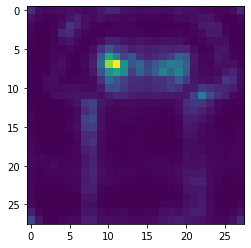

In [18]:
print('This should produce an explanation that looks like a normal explanation of the target class')
print(adv_expl.shape)
adv_expl = adv_expl.detach().cpu()
adv_expl_np = adv_expl.numpy()
adv_expl_np = adv_expl_np.reshape(224, 224)
im2 = Image.fromarray(adv_expl_np)
adv_expl2 = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(side)(im2))
adv_expl_np2 = adv_expl2.numpy()
adv_expl_np2 = adv_expl_np2.reshape(side, side)
print(adv_expl_np2.shape)
plt.imshow(adv_expl_np2)